In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [2]:
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()


(4135, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,53#_Reggae.wav,0.211,0.281,1.425,0.992,0.083,0.036,0.268,0.083,86.133,...,0.283,0.338,0.247,0.307,0.366,0.294,0.321,0.257,0.308,0.303
1,89#_Hip_hop_music.wav,0.217,0.282,1.128,0.354,0.076,0.048,0.264,0.100,123.047,...,0.256,0.266,0.337,0.350,0.303,0.286,0.274,0.318,0.301,0.212
2,3507_Hip_hop_music.wav,0.164,0.238,1.326,1.245,0.093,0.062,0.199,0.131,129.199,...,0.252,0.191,0.255,0.242,0.294,0.269,0.314,0.310,0.252,0.239
3,22186_Reggae.wav,0.344,0.419,0.523,-0.658,0.085,0.045,0.409,0.091,143.555,...,0.248,0.218,0.241,0.276,0.236,0.253,0.218,0.238,0.177,0.220
4,17170_Hip_hop_music.wav,0.134,0.185,1.950,2.469,0.064,0.053,0.170,0.074,161.499,...,0.350,0.229,0.199,0.290,0.242,0.299,0.288,0.307,0.333,0.312


In [3]:
label_dict = {'Hip':0,
              'Pop':1,
              'Reggae':2,
              'Mbalax':3
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,53#_Reggae.wav,0.246462,0.312856,0.408123,0.069042,0.178495,0.162896,0.300795,0.317647,0.187777,...,0.647208,0.521964,0.666667,0.853107,0.607143,0.642317,0.483180,0.610951,0.640449,2
1,89#_Hip_hop_music.wav,0.253538,0.313993,0.373361,0.053570,0.163441,0.217195,0.296254,0.384314,0.453968,...,0.464467,0.754522,0.788136,0.675141,0.583333,0.523929,0.669725,0.590778,0.384831,0
2,3507_Hip_hop_music.wav,0.191038,0.263936,0.396536,0.075177,0.200000,0.280543,0.222474,0.505882,0.498331,...,0.274112,0.542636,0.483051,0.649718,0.532738,0.624685,0.645260,0.449568,0.460674,0
3,22186_Reggae.wav,0.403302,0.469852,0.302551,0.029028,0.182796,0.203620,0.460840,0.349020,0.601853,...,0.342640,0.506460,0.579096,0.485876,0.485119,0.382872,0.425076,0.233429,0.407303,2
4,17170_Hip_hop_music.wav,0.155660,0.203641,0.469569,0.104860,0.137634,0.239819,0.189557,0.282353,0.731249,...,0.370558,0.397933,0.618644,0.502825,0.622024,0.559194,0.636086,0.682997,0.665730,0


In [39]:
df_copy=df
wav_files = list(df["file_name"])

In [67]:
# We retrieve all the songs for each genre
genres=['Hip','Pop','Reggae','Mbalax']
genres_files={'Hip':[],
              'Pop':[],
              'Reggae':[],
              'Mbalax':[]
             }

for genre in genres :
    for filename in wav_files:
        if genre in filename:
            genres_files[genre].append(filename)
    print("taille de "+ genre+ "= "+str(len(genres_files[genre])))           
    

taille de Hip= 1071
taille de Pop= 1096
taille de Reggae= 984
taille de Mbalax= 984


In [68]:
# retrieve only 20percent of each genre for testing
genres_files_test={'Hip':[],
              'Pop':[],
              'Reggae':[],
              'Mbalax':[]
             }
for genre in genres:
    i=0
    end=round(0.2*len(genres_files[genre]))
    for filename in genres_files[genre]:
        genres_files_test[genre].append(filename)
        i+=1
        if i==end :
            break
    print("taille de "+ genre+ "= "+str(len(genres_files_test[genre])))   
            

taille de Hip= 214
taille de Pop= 219
taille de Reggae= 197
taille de Mbalax= 197


In [77]:
# list of test files
test_files=[]
for genre in genres:
    test_files+=genres_files_test[genre]
len(test_files)

with open('testset_filenames.txt', 'w') as f:
    for file in test_files:
        f.write("%s\n" % file)

In [78]:
# Train-test split of files # Same split as used for VGG model
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

/home/samba/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samba/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Test Set Accuracy =  0.60
Test Set F-score =  0.60
ROC AUC = 0.822
Confusion matrix, without normalization
[[134  29  40  11]
 [ 43 121  22  33]
 [ 47  36  88  26]
 [  8  22  12 155]]
CPU times: user 622 ms, sys: 13.9 ms, total: 636 ms
Wall time: 1.03 s


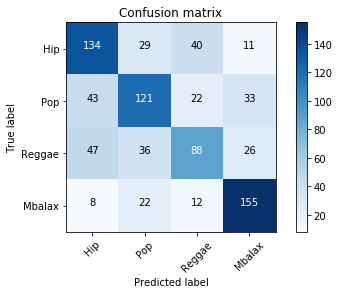

In [80]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.60
Test Set F-score =  0.59
ROC AUC = 0.824
Confusion matrix, without normalization
[[135  32  39   8]
 [ 44 112  28  35]
 [ 43  36  95  23]
 [  9  23  14 151]]
CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


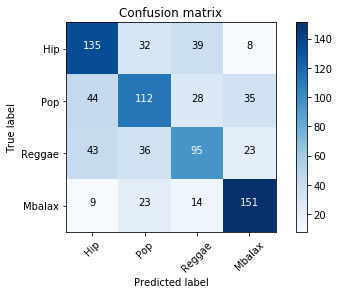

In [81]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

Test Set Accuracy =  0.63
Test Set F-score =  0.63
ROC AUC = 0.843
Confusion matrix, without normalization
[[134  30  41   9]
 [ 45 125  20  29]
 [ 34  35 112  16]
 [  9  23  16 149]]
CPU times: user 1min 5s, sys: 21.2 ms, total: 1min 5s
Wall time: 1min 7s


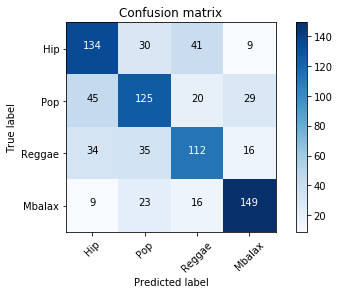

In [82]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [99]:
xgb_classifier.predict(feature_list[1:])

ValueError: feature_names mismatch: ['spectral_centroid_mean', 'spectral_centroid_std', 'spectral_bandwidth_2_mean', 'spectral_bandwidth_2_std', 'spectral_bandwidth_3_mean', 'spectral_bandwidth_3_std', 'spectral_bandwidth_4_mean', 'spectral_bandwidth_4_std', 'spectral_contrast_1_mean', 'spectral_contrast_2_mean', 'spectral_contrast_3_mean', 'spectral_contrast_4_mean', 'spectral_contrast_5_mean', 'spectral_contrast_6_mean', 'spectral_contrast_7_mean', 'spectral_contrast_1_std', 'spectral_contrast_2_std', 'spectral_contrast_3_std', 'spectral_contrast_4_std', 'spectral_contrast_5_std', 'spectral_contrast_6_std', 'spectral_contrast_7_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'mfccs_1_mean', 'mfccs_2_mean', 'mfccs_3_mean', 'mfccs_4_mean', 'mfccs_5_mean', 'mfccs_6_mean', 'mfccs_7_mean', 'mfccs_8_mean', 'mfccs_9_mean', 'mfccs_10_mean', 'mfccs_11_mean', 'mfccs_12_mean', 'mfccs_13_mean', 'mfccs_14_mean', 'mfccs_15_mean', 'mfccs_16_mean', 'mfccs_17_mean', 'mfccs_18_mean', 'mfccs_19_mean', 'mfccs_20_mean', 'mfccs_1_std', 'mfccs_2_std', 'mfccs_3_std', 'mfccs_4_std', 'mfccs_5_std', 'mfccs_6_std', 'mfccs_7_std', 'mfccs_8_std', 'mfccs_9_std', 'mfccs_10_std', 'mfccs_11_std', 'mfccs_12_std', 'mfccs_13_std', 'mfccs_14_std', 'mfccs_15_std', 'mfccs_16_std', 'mfccs_17_std', 'mfccs_18_std', 'mfccs_19_std', 'mfccs_20_std', 'chroma_stft_1_mean', 'chroma_stft_2_mean', 'chroma_stft_3_mean', 'chroma_stft_4_mean', 'chroma_stft_5_mean', 'chroma_stft_6_mean', 'chroma_stft_7_mean', 'chroma_stft_8_mean', 'chroma_stft_9_mean', 'chroma_stft_10_mean', 'chroma_stft_11_mean', 'chroma_stft_12_mean', 'chroma_stft_1_std', 'chroma_stft_2_std', 'chroma_stft_3_std', 'chroma_stft_4_std', 'chroma_stft_5_std', 'chroma_stft_6_std', 'chroma_stft_7_std', 'chroma_stft_8_std', 'chroma_stft_9_std', 'chroma_stft_10_std', 'chroma_stft_11_std', 'chroma_stft_12_std'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96']
expected spectral_contrast_3_std, mfccs_15_mean, mfccs_1_mean, mfccs_6_std, chroma_stft_5_mean, mfccs_19_std, spectral_bandwidth_4_mean, mfccs_19_mean, chroma_stft_10_std, chroma_stft_6_std, chroma_stft_7_std, mfccs_17_mean, chroma_stft_11_std, spectral_centroid_std, mfccs_3_mean, chroma_stft_3_std, spectral_contrast_6_std, mfccs_18_std, mfccs_8_std, mfccs_11_std, mfccs_3_std, chroma_stft_3_mean, chroma_stft_11_mean, spectral_contrast_5_std, chroma_stft_8_mean, chroma_stft_10_mean, mfccs_7_mean, mfccs_12_mean, chroma_stft_5_std, mfccs_4_std, chroma_stft_2_std, spectral_contrast_4_std, mfccs_7_std, mfccs_18_mean, mfccs_10_std, spectral_contrast_3_mean, mfccs_20_mean, spectral_contrast_5_mean, spectral_rolloff_mean, spectral_contrast_2_mean, spectral_contrast_1_mean, spectral_bandwidth_2_std, mfccs_2_std, mfccs_12_std, spectral_bandwidth_3_mean, mfccs_5_mean, spectral_bandwidth_3_std, spectral_bandwidth_2_mean, chroma_stft_4_mean, mfccs_6_mean, mfccs_11_mean, mfccs_20_std, mfccs_9_std, spectral_rolloff_std, mfccs_10_mean, mfccs_17_std, chroma_stft_1_mean, spectral_bandwidth_4_std, chroma_stft_8_std, spectral_contrast_6_mean, chroma_stft_1_std, chroma_stft_12_mean, chroma_stft_2_mean, mfccs_14_mean, mfccs_4_mean, mfccs_15_std, spectral_contrast_4_mean, spectral_contrast_7_mean, mfccs_9_mean, spectral_contrast_2_std, mfccs_13_mean, chroma_stft_9_std, chroma_stft_9_mean, chroma_stft_6_mean, mfccs_1_std, mfccs_16_mean, spectral_centroid_mean, mfccs_8_mean, spectral_contrast_7_std, mfccs_13_std, mfccs_2_mean, mfccs_16_std, chroma_stft_4_std, chroma_stft_12_std, mfccs_14_std, spectral_contrast_1_std, chroma_stft_7_mean, mfccs_5_std in input data
training data did not have the following fields: f21, f4, f51, f87, f9, f61, f90, f55, f94, f3, f96, f19, f57, f69, f44, f12, f31, f77, f25, f85, f26, f46, f56, f45, f6, f70, f64, f13, f86, f62, f29, f15, f14, f24, f34, f11, f83, f80, f8, f84, f67, f40, f27, f68, f37, f59, f33, f73, f36, f92, f47, f88, f30, f54, f32, f50, f28, f66, f75, f89, f18, f58, f63, f53, f71, f35, f10, f95, f17, f22, f7, f23, f39, f60, f16, f5, f41, f2, f1, f38, f0, f79, f52, f82, f48, f42, f78, f72, f65, f43, f91, f74, f93, f49, f76, f81, f20

### Support Vector Machines

/home/samba/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test Set Accuracy =  0.62
Test Set F-score =  0.62
ROC AUC = 0.841
Confusion matrix, without normalization
[[137  30  38   9]
 [ 48 121  24  26]
 [ 36  35 106  20]
 [  9  23  17 148]]
CPU times: user 20.1 s, sys: 55 ms, total: 20.1 s
Wall time: 20.2 s


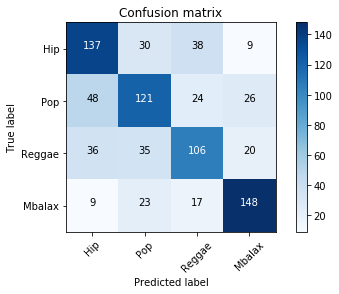

In [83]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

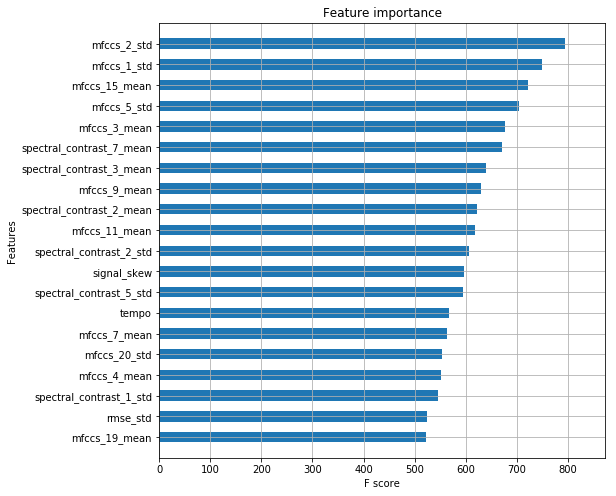

In [84]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [85]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.01121707, 0.00919877, 0.01579383, 0.01012301, 0.01314019,
       0.03760293, 0.00740181, 0.01119562, 0.01309322, 0.00825624,
       0.00869228, 0.00705362, 0.00710473, 0.00619591, 0.00843506,
       0.        , 0.        , 0.00839526, 0.01430472, 0.01034082,
       0.00853806, 0.00913624, 0.0093743 , 0.00915198, 0.00656488,
       0.01197544, 0.00766808, 0.00728824, 0.01303688, 0.00847195,
       0.00880526, 0.00822507, 0.0065262 , 0.00938256, 0.02152612,
       0.01452174, 0.01173656, 0.00794941, 0.00887269, 0.01066846,
       0.00761168, 0.01411054, 0.0095435 , 0.01305379, 0.0114732 ,
       0.01718435, 0.00695066, 0.02105542, 0.0116195 , 0.00779377,
       0.00911237, 0.00921076, 0.00738704, 0.02679436, 0.03014666,
       0.013107  , 0.00831293, 0.0281639 , 0.0096092 , 0.0131368 ,
       0.00808404, 0.00644596, 0.00799437, 0.01287661, 0.00889508,
       0.00791671, 0.00722552, 0.00693947, 0.00783741, 0.00786192,
       0.00981224, 0.00690191, 0.00843781, 0.00713254, 0.00811

In [86]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Test Set Accuracy =  0.54
Test Set F-score =  0.54
ROC AUC = 0.768

Stats for top 20 features:
Test Set Accuracy =  0.58
Test Set F-score =  0.58
ROC AUC = 0.808

Stats for top 30 features:
Test Set Accuracy =  0.61
Test Set F-score =  0.61
ROC AUC = 0.833



### Ensemble of XGB and VGG

In [87]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

ValueError: operands could not be broadcast together with shapes (827,4) (827,7) 

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [ ]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

In [ ]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.48
Test Set F-score =  0.48
ROC AUC = 0.716
Confusion matrix, without normalization
[[102  46  46  20]
 [ 54  96  34  35]
 [ 41  43  78  35]
 [ 13  26  40 118]]
CPU times: user 6.08 s, sys: 3.83 ms, total: 6.08 s
Wall time: 6.1 s


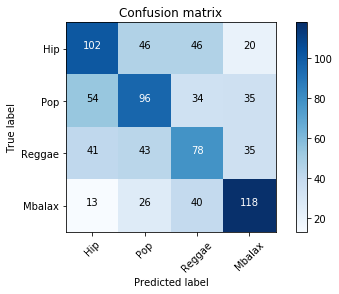

In [88]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.61
Test Set F-score =  0.61
ROC AUC = 0.835
Confusion matrix, without normalization
[[131  36  41   6]
 [ 44 118  31  26]
 [ 40  31 109  17]
 [  9  23  17 148]]
CPU times: user 1min, sys: 10.9 ms, total: 1min
Wall time: 1min


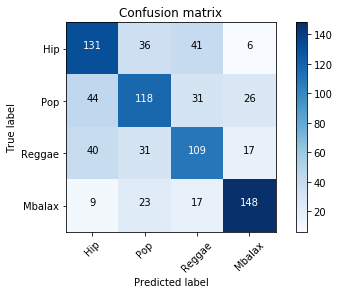

In [89]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)